# Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%shell
#clone Mask_RCNN repo and install packages
#git clone https://github.com/matterport/Mask_RCNN
cd /content/drive/My\ Drive/Tracker/
python setup.py install 

running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
reading manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/__init__.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/parallel_model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/config.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/visualize.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/model.py -> build/bdist.linux-x86_64/egg/mrcnn
byte-compiling bu

In [3]:
'''
TensorFlow 2 gives: AttributeError: module 'tensorflow' has no attribute 'placeholder'
because MaskRCNN is using TF 1
So downgrade to 1 (default version in Colab is 2?)
'''
%tensorflow_version 1.x

TensorFlow 1.x selected.


# Mask R-CNN - Inspect ScrANTon Trained Model

In [4]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import pycocotools
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils

os.chdir("/content/drive/My Drive/Tracker")
ROOT_DIR = os.getcwd()

#TFconfig = ConfigProto()
#TFconfig.gpu_options.allow_growth = True
#session = InteractiveSession(config=TFconfig)

# Import Mask RCNN
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.model import log2_graph

from PIL import Image
import imageio
from ants import ants

MODEL_DIR = os.path.join(ROOT_DIR, "logs")

VERION:  3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]


Using TensorFlow backend.


## Configurations

In [5]:
tempConfig = ants.AntConfig()
ANT_DIR = os.path.join(ROOT_DIR, "data/ant")

In [6]:
class InferenceConfig(tempConfig.__class__):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024

    STEPS_PER_EPOCH = 100
    VALIDATION_STEPS = 5

AntConfig = InferenceConfig()
#AntConfig.display()

# Examine COCO object

In [7]:
antsCOCO = COCO(os.path.join(ANT_DIR, "antsCOCO_resized.json"))

loading annotations into memory...
Done (t=29.97s)
creating index...
index created!


In [8]:
maxDim = 0
minDim = 5000
for id in antsCOCO.getImgIds():
  height = antsCOCO.loadImgs(ids=[id])[0]['height']
  width = antsCOCO.loadImgs(ids=[id])[0]['width']
  maxDim = max(maxDim,height,width)
  minDim = min(minDim,height,width)
#for x in antsCOCO.loadImgs
#antsCOCO.loadImgs(ids=[antsCOCO.anns[1]['image_id']])['height']
#antsCOCO.loadNumpyAnnotations(np.ndarray([1,2,3,4,5,6,7,8]))
print("Maximum Dimension: ",maxDim)
print("Minimum Dimension: ",minDim)

Maximum Dimension:  1024
Minimum Dimension:  1024


## Notebook Preferences

In [9]:
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0
TEST_MODE = "inference"

def get_ax(rows=1, cols=1, size=16):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# testing COCO object

In [10]:
antsCOCO = COCO(os.path.join("/content/drive/My Drive/Tracker/data/ant/", "antsCOCO_resized.json"))

loading annotations into memory...
Done (t=0.46s)
creating index...
index created!


In [11]:
#antsCOCO.getImgIds()

# Modify Dataset Class

In [12]:
class testAntDataset(ants.AntDataset):

  def load_ant(self, dataset_dir, subset):
      """Load a subset of the ant dataset.
      dataset_dir: Root directory of the dataset.
      subset: Subset to load: train or val
      """

      antsCOCO = COCO(os.path.join(dataset_dir, "antsCOCO_original.json"))

      # Create subset
      if subset == "train":
        subset_ids = random.sample(antsCOCO.getImgIds(),int(len(antsCOCO.getImgIds())*0.9))
      elif subset == "val":
        subset_ids = random.sample(antsCOCO.getImgIds(),int(len(antsCOCO.getImgIds())*0.1))

      # Add classes
      for i in antsCOCO.getCatIds():
          self.add_class("ScrANTonDataset", i, antsCOCO.loadCats(i)[0]["name"])
      
      # Add images
      for i in subset_ids:#antsCOCO.getImgIds():
          if antsCOCO.loadAnns(antsCOCO.getAnnIds(imgIds=[i],catIds=antsCOCO.getCatIds())):
              self.add_image(
                      "ScrANTonDataset", image_id=i,
                      path = antsCOCO.imgs[i]['file_name'],
                      width= antsCOCO.imgs[i]["width"],
                      height=antsCOCO.imgs[i]["height"],
                      annotations=antsCOCO.loadAnns(antsCOCO.getAnnIds(imgIds=[i], catIds=antsCOCO.getCatIds())))

  def load_mask(self, image_id):
  
    """Generate instance masks for an image.
    Returns:
    masks: A bool array of shape [height, width, instance count] with
        one mask per instance.
    class_ids: a 1D array of class IDs of the instance masks.
    """
    image_info = self.image_info[image_id]
    instance_masks = []
    class_ids = []
    annotations = self.image_info[image_id]["annotations"]
    # Build mask of shape [height, width, instance_count] and list
    # of class IDs that correspond to each channel of the mask.
    for annotation in annotations:
        class_id = annotation['category_id']    #self.map_source_class_id("{}".format(annotation['category_id']))
        if class_id:
            m = self.annToMask(annotation, image_info["height"],
                              image_info["width"])
            # Some objects are so small that they're less than 1 pixel area
            # and end up rounded out. Skip those objects.
            if m.max() < 1:
                continue
            # Is it a crowd? If so, use a negative class ID.
            if annotation['iscrowd']:
                # Use negative class ID for crowds
                class_id *= -1
                # For crowd masks, annToMask() sometimes returns a mask
                # smaller than the given dimensions. If so, resize it.
                if m.shape[0] != image_info["height"] or m.shape[1] != image_info["width"]:
                    m = np.ones([image_info["height"], image_info["width"]], dtype=bool)
            instance_masks.append(m)
            class_ids.append(class_id)

    # Pack instance masks into an array
    if class_ids:
        mask = np.stack(instance_masks, axis=2).astype(np.bool)
        class_ids = np.array(class_ids, dtype=np.int32)
        return mask, class_ids
    else:
        # Call super class to return an empty mask
        return super(AntDataset, self).load_mask(image_id)

  #def load_image(self,image_id):


  def image_reference(self, image_id):
    """Return the path of the image."""
    info = self.image_info[image_id]
    return info["path"]
    # if info["source"] == "ant":
    #     return info["path"]
    # else:
    #     super(self.__class__, self).image_reference(image_id)

  def annToRLE(self, ann, height, width):
  
    """
    Convert annotation which can be polygons, uncompressed RLE to RLE.
    :return: binary mask (numpy 2D array)
    """

    segm = ann['segmentation']
    if isinstance(segm, list):
        # polygon -- a single object might consist of multiple parts
        # we merge all parts into one mask rle code
        rles = maskUtils.frPyObjects(segm, height, width)
        rle = maskUtils.merge(rles)
    elif isinstance(segm['counts'], list):
        # uncompressed RLE
        rle = maskUtils.frPyObjects(segm, height, width)
    else:
        # rle
        rle = ann['segmentation']
    return rle

  def annToMask(self, ann, height, width):
    """
    Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
    :return: binary mask (numpy 2D array)
    """
    rle = self.annToRLE(ann, height, width)
    m = maskUtils.decode(rle)
    return m

  def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = AntDataset()
    dataset_train.load_ant(args.dataset, "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = AntDataset()
    dataset_val.load_ant(args.dataset, "val")
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=30,
                layers='heads')

## Load Validation Dataset

In [13]:
# Load validation dataset
dataset = testAntDataset()#ants.AntDataset()
dataset.load_ant(ANT_DIR, "val")
# Must call before using/ the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

loading annotations into memory...
Done (t=0.58s)
creating index...
index created!
Images: 113
Classes: ['BG', 'Full Ant', 'Abdomen', 'Thorax', 'Head']


## Load Model

In [14]:
#with tf.device(DEVICE):
model = modellib.MaskRCNN(mode=TEST_MODE, model_dir=MODEL_DIR,
                            config=AntConfig)
    
weights_path = os.path.join(ROOT_DIR,r"logs/mask_rcnn_scrantondata_0002.h5")
if not os.path.exists(weights_path):
    utils.download_trained_weights(weights_path)
print("Using device: ",DEVICE)
print("Loading weights from: ", weights_path)
model.load_weights(weights_path, by_name=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Using device:  /gpu:0
Loading weights from:  /content/drive/My Drive/Tracker/logs/mask_rcnn_scrantondata_0002.h5


## Run Detection

In [18]:
os.chdir(os.path.join(ROOT_DIR,"data/ant"))

image_id = random.choice(dataset.image_ids)

image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, AntConfig, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id,dataset.image_reference(image_id)))

startdetect = time.time()
results = model.detect([image], verbose=1)
enddetect = time.time()
print("Detection took ", enddetect - startdetect, "seconds.")

# Display results
ax = get_ax(1)
r = results[0]

startvis = time.time()
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax, title="Predictions")
endvis = time.time()
print("Visualization took ", endvis - startvis, "seconds.")

Output hidden; open in https://colab.research.google.com to view.

image ID: ScrANTonDataset.cjxtf45skgzeh0848qnytm5db (12) cjxtf45skgzeh0848qnytm5db.jpg


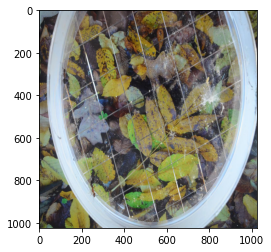

In [16]:
image_id = random.choice(dataset.image_ids)

image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, AntConfig, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

plt.imshow(image)